In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measurement = Base.classes.measurement
# reflect the tables
session = Session(engine)

query_1 = session.query(Station).limit(10)

df_station = pd.read_sql_query(query_1.statement, session.get_bind())
df_station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [24]:
query_2 = session.query(Measurement).limit(10)

df_measurement = pd.read_sql_query(query_2.statement, session.get_bind())
df_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [25]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
table_list = [df_measurement, df_station]

In [27]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [128]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Only use date and prcp

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
prcp_query = (session
    .query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= query_date))

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql_query(prcp_query.statement, session.get_bind())

# Sort the dataframe by date
df_prcp.sort_values(by = 'date')
# df_prcp.head()


Query Date:  2016-08-23


,date,prcp
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


Text(0, 0.5, 'Amount of rainfall (inches)')

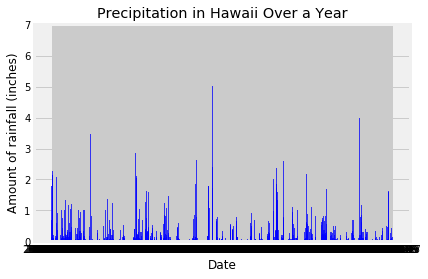

In [129]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = df_prcp['date']
y_axis = df_prcp['prcp']

plt.bar(x_axis, y_axis, alpha = .75, color = 'b')
plt.title("Precipitation in Hawaii Over a Year")
plt.xlabel("Date")
plt.ylabel("Amount of rainfall (inches)")


In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
count = len(df_prcp['prcp'])
sum = df_prcp['prcp'].sum()
mean = df_prcp['prcp'].mean()
std = df_prcp['prcp'].std()
min = df_prcp['prcp'].min() 
max = df_prcp['prcp'].max()

quartiles = df_prcp['prcp'].quantile([.25, .5, .75])
lowerq = quartiles[.25]
upperq = quartiles[.75]
median = quartiles[.5]

data = {'summary': ["count", "sum", "mean", "std", "min", "25%", "50%", "75%", "max"],
        'precipitation': [count, sum, mean, std, min, lowerq, median, upperq, max]}
df_summary = pd.DataFrame(data=data)
df_summary.head(10)

,summary,precipitation
0,count,2230.000000
1,sum,358.280000
2,mean,0.177279
3,std,0.461190
4,min,0.000000
5,25%,0.000000
6,50%,0.020000
7,75%,0.130000
8,max,6.700000


In [79]:
# Design a query to show how many stations are available in this dataset?
query_station = (session.query(Station.station)
                .count())
print(f"There are {query_station} stations.")

There are 9 stations.


In [106]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count = (session.query(Measurement.station, func.count(Measurement.station))
        .group_by(Measurement.station))

df_active = pd.read_sql_query(count.statement, session.get_bind())
df_active.head(10)



,station,count_1
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [98]:
print("Station USC00519281 is the most active station.")

Station USC00519281 is the most active station.


In [109]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tobs_avg = (session.query(Measurement.station, func.avg(Measurement.tobs))
       .group_by(Measurement.station))
df_tobs_avg = pd.read_sql_query(tobs_avg.statement, session.get_bind())
df_tobs_avg.head(10)

,station,avg_1
0,USC00511918,71.615968
1,USC00513117,72.689184
2,USC00514830,74.873297
3,USC00516128,70.915008
4,USC00517948,74.684402
5,USC00518838,72.724070
6,USC00519281,71.663781
7,USC00519397,74.553231
8,USC00519523,74.543649


In [110]:
print("Most active station has an average temperature of 71.66")

Most active station has an average temperature of 71.66


In [117]:
tobs_min = (session.query(func.min(Measurement.tobs)))

df_tobs_min = pd.read_sql_query(tobs_min.statement, session.get_bind())
df_tobs_min.head()

,min_1
0,53.0


In [119]:
print("The minimum temperature observed is 53 degrees.")

The minimum temperature observed is 53 degrees.


In [120]:
tobs_max =(session.query(func.max(Measurement.tobs)))

df_tobs_max = pd.read_sql_query(tobs_max.statement, session.get_bind())
df_tobs_max.head()

,max_1
0,87.0


In [121]:
print("The maximum temperature observed was 87 degrees.")

The maximum temperature observed was 87 degrees.


In [145]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_tobs_query = (session.query(Measurement.date, Measurement.tobs)
                     .filter(Measurement.date >= query_date)
                     .filter(Measurement.station == "USC00519281"))

df_highest_tobs_query = pd.read_sql_query(highest_tobs_query.statement, session.get_bind())
df_highest_tobs_query.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Text(0, 0.5, 'Temperature Observed (F)')

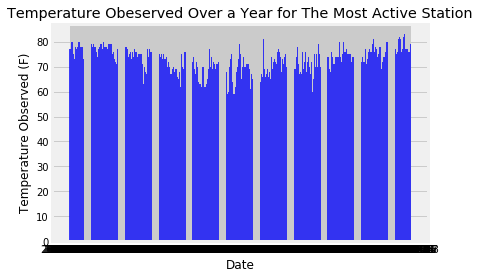

In [146]:
x_axis = df_highest_tobs_query['date']
y_axis = df_highest_tobs_query['tobs']

plt.bar(x_axis, y_axis, alpha = .75, color = 'b')
plt.title("Temperature Obeserved Over a Year for The Most Active Station")
plt.xlabel("Date")
plt.ylabel("Temperature Observed (F)")

#unfortunately couldn't figure out how to use bins/histogram

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
